In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd /content/drive/'My Drive'/'Colab Notebooks'/'CNN_Covid_Project'

/content/drive/My Drive/Colab Notebooks/CNN_Covid_Project


In [4]:
TRAIN_PATH = "data/train"
VAL_PATH = "data/test"

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import * 
from keras.preprocessing import image

import keras.backend as K
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from time import time



from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import numpy as np
import itertools
import os



In [6]:
im_height = 512
im_width = 512
batch_size = 32
epochs = 10


if not os.path.exists("save_denseNet201_weights"):
    os.makedirs("save_denseNet201_weights")

In [7]:
train_image_generator = ImageDataGenerator( rescale=1./255,
                                            shear_range=0.2,
                                            zoom_range=0.2,                                    
                                            horizontal_flip=True)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

In [8]:
train_data_gen = train_image_generator.flow_from_directory(directory='/content/drive/My Drive/Colab Notebooks/data/train',
                                                           batch_size=batch_size,
                                                           shuffle=True,
                                                           target_size=(im_height, im_width),
                                                           class_mode='categorical')
    
total_train = train_data_gen.n




val_data_gen = validation_image_generator.flow_from_directory(directory='/content/drive/My Drive/Colab Notebooks/data/test',
                                                              batch_size=batch_size,
                                                              shuffle=False,
                                                              target_size=(im_height, im_width),
                                                              class_mode='categorical')
    
total_val = val_data_gen.n





test_data_gen = test_image_generator.flow_from_directory( directory='/content/drive/My Drive/Colab Notebooks/data/val',
                                                          batch_size=batch_size,
                                                          shuffle=False,
                                                          target_size=(im_height, im_width),
                                                          class_mode='categorical')
    
total_test = test_data_gen.n

Found 1292 images belonging to 2 classes.
Found 236 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [9]:
covn_base = tf.keras.applications.DenseNet201(weights='imagenet', include_top = False,input_shape=(im_height,im_width,3))
covn_base.trainable = False

model = tf.keras.Sequential()
model.add(covn_base)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(rate=0.2)) 
model.add(tf.keras.layers.Dense(2, activation='softmax'))
model.summary() 

74842112/74836368 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 16, 16, 1920)      18321984  
_________________________________________________________________
flatten (Flatten)            (None, 491520)            0         
_________________________________________________________________
dropout (Dropout)            (None, 491520)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 983042    
Total params: 19,305,026
Trainable params: 983,042
Non-trainable params: 18,321,984
_________________________________________________________________


In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
reduce_lr = ReduceLROnPlateau(
                                monitor='val_loss', 
                                factor=0.1, 
                                patience=2, 
                                mode='auto',
                                verbose=1
                             )


checkpoint = ModelCheckpoint(
                                filepath='./save_denseNet201_weights/DenseNet201.ckpt',
                                monitor='val_acc', 
                                save_weights_only=False, 
                                save_best_only=True, 
                                mode='auto',
                                period=1
                            )


In [12]:
history = model.fit(x=train_data_gen,
                    steps_per_epoch=total_train // batch_size,
                    epochs=epochs,
                    validation_data=val_data_gen,
                    validation_steps=total_val // batch_size,
                    callbacks=[checkpoint, reduce_lr])

Epoch 1/10
40/40 [==============================] - 1012s 25s/step - loss: 0.4490 - accuracy: 0.9460 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 2/10
40/40 [==============================] - 83s 2s/step - loss: 0.0774 - accuracy: 0.9881 - val_loss: 0.0045 - val_accuracy: 0.9955
Epoch 3/10
40/40 [==============================] - 83s 2s/step - loss: 0.0233 - accuracy: 0.9937 - val_loss: 2.0701e-04 - val_accuracy: 1.0000
Epoch 4/10
40/40 [==============================] - 83s 2s/step - loss: 0.0052 - accuracy: 0.9968 - val_loss: 3.4139e-04 - val_accuracy: 1.0000
Epoch 5/10
40/40 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9960WARNING:tensorflow:Can save best model only with val_acc available, skipping.

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
40/40 [==============================] - 83s 2s/step - loss: 0.0101 - accuracy: 0.9960 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 6/10
40/40 [==============================

In [13]:
model.save_weights('./save_denseNet201_weights/DenseNet201.ckpt',save_format='tf')

In [14]:
model.save("DenseNet201.h5")

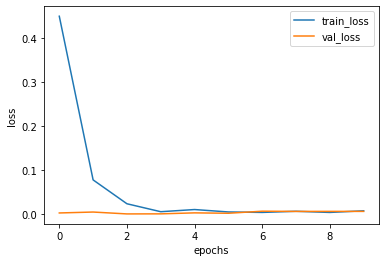

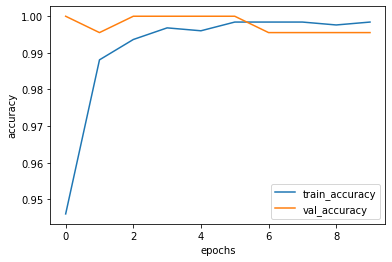

In [15]:
history_dict = history.history
train_loss = history_dict["loss"]
train_accuracy = history_dict["accuracy"]
val_loss = history_dict["val_loss"]
val_accuracy = history_dict["val_accuracy"]

#magnitude of the loss
plt.figure()
plt.plot(range(epochs), train_loss, label='train_loss')
plt.plot(range(epochs), val_loss, label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

# accuracy rate
plt.figure()
plt.plot(range(epochs), train_accuracy, label='train_accuracy')
plt.plot(range(epochs), val_accuracy, label='val_accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [16]:
scores = model.evaluate(val_data_gen, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

8/8 [==============================] - 4s 475ms/step - loss: 0.0069 - accuracy: 0.9958
Test loss: 0.006903164554387331
Test accuracy: 0.9957627058029175


Instructions for updating:
Please use Model.predict, which supports generators.


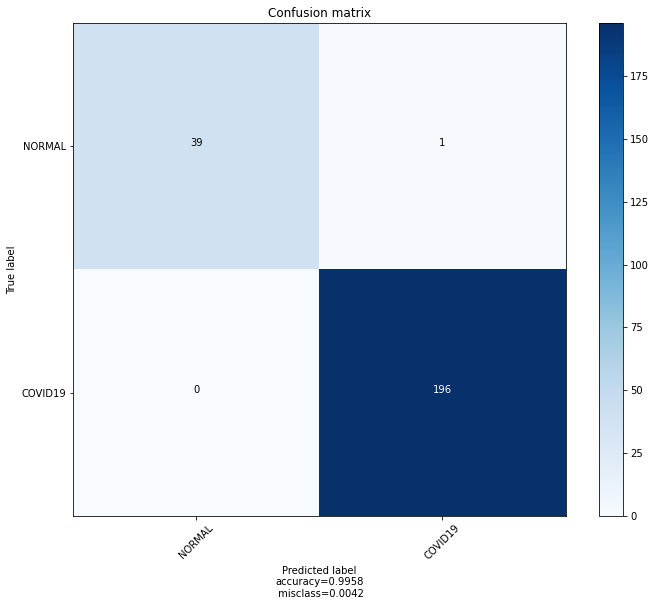

In [17]:
def plot_confusion_matrix(cm, target_names,title='Confusion matrix',cmap=None,normalize=False):
    accuracy = np.trace(cm) / float(np.sum(cm)) #Calculating accuracy
    misclass = 1 - accuracy #Calculation error rate
    if cmap is None:
        cmap = plt.get_cmap('Blues') #Set color to blue
    plt.figure(figsize=(10, 8)) #Set window size
    plt.imshow(cm, interpolation='nearest', cmap=cmap) #display picture
    plt.title(title) #show heading
    plt.colorbar() #Draw color bar

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45) #x-coordinate label rotated 45 degrees
        plt.yticks(tick_marks, target_names) #y-coordinate

    if normalize:
        cm = cm.astype('float32') / cm.sum(axis=1)
        cm = np.round(cm,2) #Keep two decimal places for numbers
        

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])): #takeCm.shape[0],Cm.shapeElements in [1] form tuples, traversing each number in the tuple
        if normalize: #Standardization
            plt.text(j, i, "{:0.2f}".format(cm[i, j]), #Keep two decimal places
                     horizontalalignment="center",  #Number in the middle of the box
                     color="white" if cm[i, j] > thresh else "black")  #Set Font Color
        else:  #Nonstandard
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",  #Number in the middle of the box
                     color="white" if cm[i, j] > thresh else "black") #Set Font Color

    plt.tight_layout() #Automatically adjust subgraph parameters to fill the entire image area
    plt.ylabel('True label') #Labels in the y direction
    plt.xlabel("Predicted label\naccuracy={:0.4f}\n misclass={:0.4f}".format(accuracy, misclass)) #Labels in x direction
    plt.show() #display picture

labels = ['NORMAL','COVID19']

# Overall accuracy of prediction validation set data
Y_pred = model.predict_generator(val_data_gen, total_val // batch_size + 1)
# Convert the predicted result to a one hit vector
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# Computing confusion matrix
confusion_mtx = confusion_matrix(y_true = val_data_gen.classes,y_pred = Y_pred_classes)
# Draw confusion matrix
plot_confusion_matrix(confusion_mtx, target_names=labels)

In [18]:
print(classification_report(val_data_gen.classes, Y_pred_classes, target_names=labels))

              precision    recall  f1-score   support

      NORMAL       1.00      0.97      0.99        40
     COVID19       0.99      1.00      1.00       196

    accuracy                           1.00       236
   macro avg       1.00      0.99      0.99       236
weighted avg       1.00      1.00      1.00       236



In [19]:
def predict_print(path):
  #Getting category codes for datasets
  class_indices = train_data_gen.class_indices 
  #Save codes and corresponding categories in a dictionary
  inverse_dict = dict((val, key) for key, val in class_indices.items()) 
  #Load Test Picture
  img = Image.open(path)
  # resize the picture to 224x224 size
  img = img.resize((im_width, im_height))
  #Convert Grayscale Grayscale to RGB Mode
  img = img.convert("RGB")
  # normalization
  img1 = np.array(img) / 255.
  # Add a dimension to the picture to match the network model
  img1 = (np.expand_dims(img1, 0))
  #Converting predictions to probability values
  result = np.squeeze(model.predict(img1))
  predict_class = np.argmax(result)
  #print(inverse_dict[int(predict_class)],result[predict_class])
  #Print the predicted results on the picture
  plt.title([inverse_dict[int(predict_class)],result[predict_class]])
  #display picture
  plt.imshow(img)

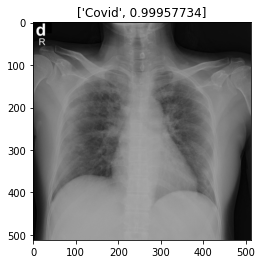

In [20]:
predict_print("/content/drive/My Drive/Colab Notebooks/data/test/Covid/COVID-19 (5).png")

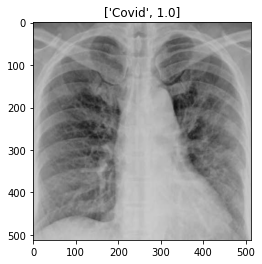

In [21]:
predict_print("/content/drive/My Drive/Colab Notebooks/data/test/Covid/COVID-19 (6).png")

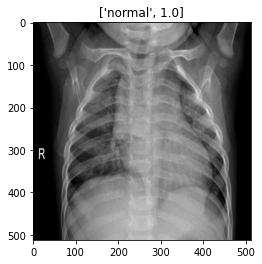

In [22]:
predict_print("/content/drive/My Drive/Colab Notebooks/data/test/normal/NORMAL (7).png")

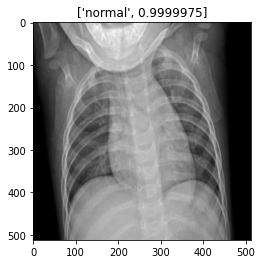

In [23]:
predict_print("/content/drive/My Drive/Colab Notebooks/data/test/normal/NORMAL (10).png")